In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LSTM, Dropout

#### Helper Functions

In [ ]:
def preprocess_categorical(x_train, x_test, categorical):
    # Columns to be embedded: map to range [0, # values)
    for cat in categorical:
        raw_vals, val_map = np.unique(x_train[cat]), {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i  
        x_train.loc[:,cat] = x_train.loc[:,cat].map(val_map)
        x_test.loc[:,cat] = x_test.loc[:,cat].map(val_map) 
        
    return x_train, x_test

def prepare_data(x, y, featurecolumns, categorical, numeric, steps):
    _x, _y = [], []
    #columns = categorical + numeric
    for col in featurecolumns:
        inp = []
        for i in range(len(x) - steps): 
            v = x.iloc[i:(i + steps)][col].values #.astype(np.float32)
            if col in numeric: 
                v = v.reshape(steps, 1)
            inp.append(v)
        inp = np.stack(inp, axis = 0)
        _x.append(inp)   
        
    for i in range(len(x) - steps): 
      _y.append(y.iloc[i + steps].values)
    _y = np.array(_y) #.astype(np.float32)
    
    return _x, _y

#### Data Processing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Neural Networks/Dataset/fraudTrain.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Neural Networks/Dataset/fraudTest.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [ ]:
df.isnull().any()

Unnamed: 0               False
trans_date_trans_time    False
cc_num                   False
merchant                 False
category                 False
amt                      False
first                    False
last                     False
gender                   False
street                   False
city                     False
state                    False
zip                      False
lat                      False
long                     False
city_pop                 False
job                      False
dob                      False
trans_num                False
unix_time                False
merch_lat                False
merch_long               False
is_fraud                 False
dtype: bool

In [ ]:
df.groupby(['is_fraud'])['is_fraud'].count() #0.005 50

is_fraud
0    1289169
1       7506
Name: is_fraud, dtype: int64

In [ ]:
# From date extract day, month, year for learning embeddings
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], infer_datetime_format=True)
df["Day"] = df["trans_date_trans_time"].dt.day
df["Month"] = df["trans_date_trans_time"].dt.month
df["Year"] = df["trans_date_trans_time"].dt.year
# df['lat/long'] = df['lat'].astype(str) + "-" + df['long'].astype(str)
# df['merch lat/long'] = df['merch_lat'].astype(str) + "-" + df['merch_long'].astype(str)

df = df.drop(columns=['trans_date_trans_time','Unnamed: 0', 'trans_num','unix_time','cc_num'])

# From date extract day, month, year for learning embeddings
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"], infer_datetime_format=True)
df_test["Day"] = df_test["trans_date_trans_time"].dt.day
df_test["Month"] = df_test["trans_date_trans_time"].dt.month
df_test["Year"] = df_test["trans_date_trans_time"].dt.year
# df['lat/long'] = df['lat'].astype(str) + "-" + df['long'].astype(str)
# df['merch lat/long'] = df['merch_lat'].astype(str) + "-" + df['merch_long'].astype(str)

df_test = df_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'trans_num','unix_time','cc_num'])

df[:1]

,merchant,category,amt,first,last,gender,street,city,state,zip,...,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,Day,Month,Year
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,1,1,2019


In [ ]:
df_test[:1]

,merchant,category,amt,first,last,gender,street,city,state,zip,...,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,Day,Month,Year
0,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,...,-80.9355,333497,Mechanical engineer,1968-03-19,33.986391,-81.200714,0,21,6,2020


In [ ]:
df.insert(0, 'is_fraud', df.pop('is_fraud'))

df_test.insert(0, 'is_fraud', df_test.pop('is_fraud'))

In [ ]:
df_not_fraud = df[df['is_fraud'] == 0][:1000]
df_fraud = df[df['is_fraud'] == 1][:5]
                                       
df_10000 = pd.concat([df_fraud,df_not_fraud])

df_10000.groupby(['is_fraud'])['is_fraud'].count()


#df_10000=df 500000, 2500

df_test_not_fraud = df_test[df_test['is_fraud'] == 0][:1000]
df_test_fraud = df_test[df_test['is_fraud'] == 1][:5]
                                       
df_test_10000 = pd.concat([df_test_fraud,df_test_not_fraud])

df_test_10000.groupby(['is_fraud'])['is_fraud'].count()

is_fraud
0    1000
1       5
Name: is_fraud, dtype: int64

In [ ]:
# df_10000.replace(to_replace = np.nan, value = -1) 

# df_test_10000.replace(to_replace = np.nan, value = -1) 

In [ ]:
# df_10000 = df_10000.reset_index()
# df_test_10000 = df_10000.reset_index()

In [ ]:
# import seaborn as sns
# sns.displot(df_10000['is_fraud'])

In [ ]:
X_train = df_10000.iloc[:,1:].copy()
y_train = df_10000.iloc[:,:1]

X_test = df_test_10000.iloc[:,1:].copy()
y_test = df_test_10000.iloc[:,:1]

# X_test = X_test.sample(frac=1)
# y_test = y_test.sample(frac=1)


# X = df_10000.iloc[:,1:].copy()
# y = df_10000.iloc[:,:1]



In [ ]:
# X.isnull().any()

In [ ]:
all_cols = df.columns
feature_cols = [i for i in df_10000.columns if i != 'is_fraud']

numeric_cols = X_train._get_numeric_data().columns

categorical_cols = [i for i in df_10000.columns if i not in numeric_cols and i != 'is_fraud']

print ("All Columns: ", len(all_cols))
print ("Numeric Columns: ", len(numeric_cols))
print ("Categorical Columns: ", len(categorical_cols))

All Columns:  21
Numeric Columns:  10
Categorical Columns:  10


In [ ]:
feature_cols

['merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'merch_lat',
 'merch_long',
 'Day',
 'Month',
 'Year']

In [ ]:
for categorical_col in categorical_cols:
  X_train.loc[:,categorical_col] = X_train.loc[:,categorical_col].astype("category").cat.codes
  X_test.loc[:,categorical_col] = X_test.loc[:,categorical_col].astype("category").cat.codes

<ipython-input-117-37c82292ad92>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.loc[:,categorical_col] = X_train.loc[:,categorical_col].astype("category").cat.codes
<ipython-input-117-37c82292ad92>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.loc[:,categorical_col] = X_test.loc[:,categorical_col].astype("category").cat.codes
<ipython-input-117-37c82292ad92>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=True)

In [ ]:
X_train[:1]

,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,Day,Month,Year
2449,305,4,281.06,119,214,1,310,105,26,28611,35.9946,-81.7266,885,320,468,36.430124,-81.179483,2,1,2019


In [ ]:
steps = 1 # hyper-parameter: window size

train_x, test_x = preprocess_categorical(X_train, X_test, categorical_cols)
train_x, train_y = prepare_data(X_train, y_train,feature_cols, categorical_cols, numeric_cols, steps)
test_x, test_y = prepare_data(X_test, y_test,feature_cols, categorical_cols, numeric_cols, steps)

# train_x, test_x = preprocess_categorical(X_train, X_test, categorical_cols)
# # train_x, train_y = X_train, y_train
# test_x, test_y = test_x, y_test

In [ ]:
# for categorical_col in categorical_cols:
#   print(f'Number of unique values in {X_train[categorical_col]} is {X_train[categorical_col].nunique()}')  

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# # transform data
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.fit_transform(test_x)



#### Model

In [ ]:
inputs, embeddings = [], []
lr = 0.001
le = 0.0001
dp = 0.5

for cat in categorical_cols:
    cat_input = Input(shape=(steps,), name="".join([cat.replace(" ", ""),"_inp"]))
    unique_cat  = X_train[cat].nunique()
    # embedding_size = min(np.ceil((unique_cat)/2), 1)
    # embedding_size = int(embedding_size)
    embedding_size = unique_cat - 1
    cat_dim = unique_cat 
    inputs.append(cat_input)
    embeddings.append(Embedding(cat_dim, embedding_size, #input_length = steps,
            name="".join([cat.replace(" ", ""),"_emb"]))(cat_input))
     
for num in numeric_cols:
    num_input = Input(shape=(steps,1), 
          name="".join([num.replace(" ", ""),"_inp"]))
    inputs.append(num_input)
    embeddings.append(num_input)
    
x = Concatenate(name="concat")(embeddings)
x = LSTM(22, kernel_regularizer=l2(le), recurrent_regularizer=l2(le),
        return_sequences=True)(x)
x = Dropout(dp)(x)
x = Dense(22, activation="relu")(x) #kernel_regularizer=l2(le)
output = Dense(1, activation='sigmoid', name="output")(x)

model = Model(inputs, output, name = "fraud_model")
model.compile(optimizer = Adam(learning_rate = lr), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_x, train_y, epochs = 10, batch_size = 24, verbose = 2,validation_split=0.5,validation_data= (test_x, test_y))

#model.fit(X_train,y_train,epochs=10,batch_size=5,validation_split=0.05,verbose=2,validation_data= (X_test, y_test));

scores = model.evaluate(train_x, train_y,verbose=1,batch_size=24)

Epoch 1/10
42/42 - 14s - loss: 0.5169 - accuracy: 0.8446 - val_loss: 0.2857 - val_accuracy: 0.9960 - 14s/epoch - 330ms/step
Epoch 2/10
42/42 - 2s - loss: 0.1485 - accuracy: 0.9960 - val_loss: 0.0512 - val_accuracy: 0.9960 - 2s/epoch - 52ms/step
Epoch 3/10
42/42 - 1s - loss: 0.0566 - accuracy: 0.9960 - val_loss: 0.0334 - val_accuracy: 0.9960 - 868ms/epoch - 21ms/step
Epoch 4/10
42/42 - 1s - loss: 0.0448 - accuracy: 0.9960 - val_loss: 0.0283 - val_accuracy: 0.9960 - 719ms/epoch - 17ms/step
Epoch 5/10
42/42 - 1s - loss: 0.0361 - accuracy: 0.9960 - val_loss: 0.0265 - val_accuracy: 0.9960 - 1s/epoch - 28ms/step
Epoch 6/10
42/42 - 1s - loss: 0.0323 - accuracy: 0.9960 - val_loss: 0.0260 - val_accuracy: 0.9960 - 889ms/epoch - 21ms/step
Epoch 7/10
42/42 - 1s - loss: 0.0361 - accuracy: 0.9960 - val_loss: 0.0261 - val_accuracy: 0.9960 - 924ms/epoch - 22ms/step
Epoch 8/10
42/42 - 1s - loss: 0.0294 - accuracy: 0.9960 - val_loss: 0.0263 - val_accuracy: 0.9960 - 1s/epoch - 24ms/step
Epoch 9/10
42/42 

In [ ]:
print('Accuracy: '+ str(scores[1] * 100) + '%') #{perc:.2%}
print('Loss: {:0.4f}'.format(scores[0]))

Accuracy: 99.60159659385681%
Loss: 0.0274


In [ ]:
y_pred = model.predict(test_x)

32/32 [==============================] - 1s 4ms/step


In [ ]:
test_x

[array([[150.],
        [324.],
        [280.],
        ...,
        [ nan],
        [322.],
        [110.]]),
 array([[3],
        [6],
        [0],
        ...,
        [8],
        [5],
        [3]]),
 array([[[ 24.84]],
 
        [[780.52]],
 
        [[620.33]],
 
        ...,
 
        [[ 76.79]],
 
        [[135.59]],
 
        [[ 14.17]]]),
 array([[40],
        [77],
        [77],
        ...,
        [79],
        [22],
        [55]]),
 array([[274],
        [320],
        [320],
        ...,
        [ 28],
        [285],
        [199]]),
 array([[0],
        [1],
        [1],
        ...,
        [1],
        [0],
        [1]]),
 array([[360],
        [349],
        [349],
        ...,
        [138],
        [  3],
        [143]]),
 array([[344],
        [ 39],
        [ 39],
        ...,
        [260],
        [137],
        [307]]),
 array([[40],
        [45],
        [45],
        ...,
        [36],
        [20],
        [25]]),
 array([[[79759]],
 
        [[53803]],
 
 

In [ ]:
y_pred[:,0]

array([[0.00153897],
       [0.00153667],
       [0.00153667],
       ...,
       [0.00153667],
       [0.00153668],
       [0.00153667]], dtype=float32)

Genuine Transactions Detected (True Negatives):  1000
Genuine Transactions Incorrectly Detected (False Positives):  0
Fake Transactions Missed (False Negatives):  4
Fake Transactions Detected (True Positives):  0
Total Fake Transactions:  4


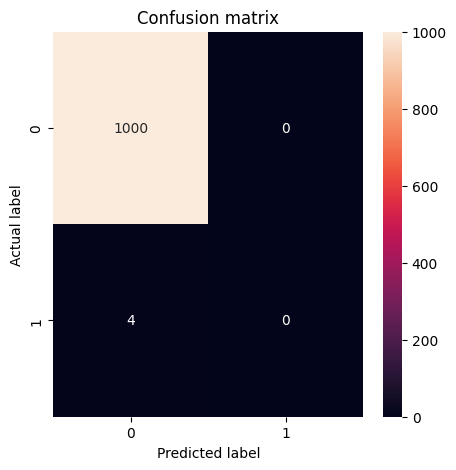

In [ ]:
# confusion_matrix(test_y, y_pred[:,0].round())
# prediction_threshold = 0.5
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(test_y, y_pred[:,0].round() )  #> prediction_threshold)
plt.figure(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt="d")
plt.title('Confusion matrix')
#plt.title('Confusion matrix @{:.2f}'.format(prediction_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Genuine Transactions Detected (True Negatives): ', conf_mat[0][0])
print('Genuine Transactions Incorrectly Detected (False Positives): ', conf_mat[0][1])
print('Fake Transactions Missed (False Negatives): ', conf_mat[1][0])
print('Fake Transactions Detected (True Positives): ', conf_mat[1][1])
print('Total Fake Transactions: ', np.sum(conf_mat[1]))

In [ ]:
#confusion_matrix(test_y, y_pred)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

auc_score = roc_auc_score(test_y, y_pred[:,0].round())

auc_score

0.5

In [ ]:
# auc_score

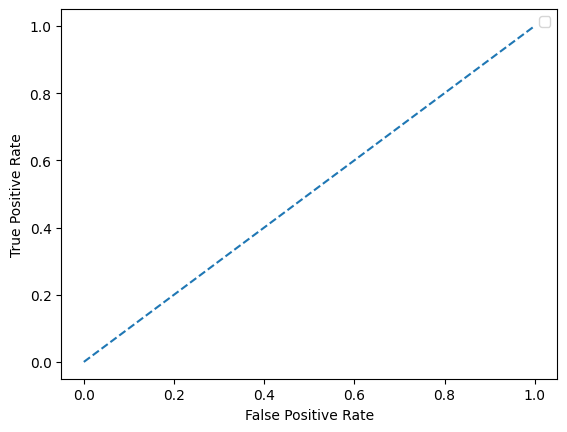

In [ ]:
# calculate roc curves
fpr, tpr,_ = roc_curve(test_y, y_pred[:,0].round())

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


Source:

Amy @GrabNGoInfo. (2023, March 28). Categorical Entity Embedding Using Python Tensorflow Keras. GrabNGoInfo. https://medium.com/grabngoinfo/categorical-entity-embedding-using-python-tensorflow-keras-dac153cbffd2